<a href="https://colab.research.google.com/github/utility001/flower_classification/blob/main/flower_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install --upgrade tf-keras
!pip install tensorflow==2.16.1
!pip install gradio
!pip install scikit-learn==1.4.2
!pip install tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 97.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      

In [2]:
import sklearn
import tensorflow as tf
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# EDA

The flowers here are not part of imagenet.

Train a pretrained model on the dataset. -- i.e transfer learning

If you want to build an image classifier but you do not have enough data to train it from scratch, then it is often a good idea to reuse the lower layers of a pretrained model, as we discussed in Chapter 11.

For example, let’s train a model to classify pictures of flowers, reusing a pretrained Xception model.

In [5]:
import tensorflow_datasets as tfds
# tfds?

In [6]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
  print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1.incompleteS5UAZP',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [8]:
print(f"The keys in the dataframe is {info.supervised_keys}")
print(f"The splits in the dataset is {info.splits}")
print(f"The labels in the dataset is {info.features['label'].names}")

The keys in the dataframe is ('image', 'label')
The splits in the dataset is {'train': <SplitInfo num_examples=3670, num_shards=2>}
The labels in the dataset is ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


The dataset as only train set.

In [9]:
# Split the dataset
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    shuffle_files=True,
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [10]:
train_set_raw

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

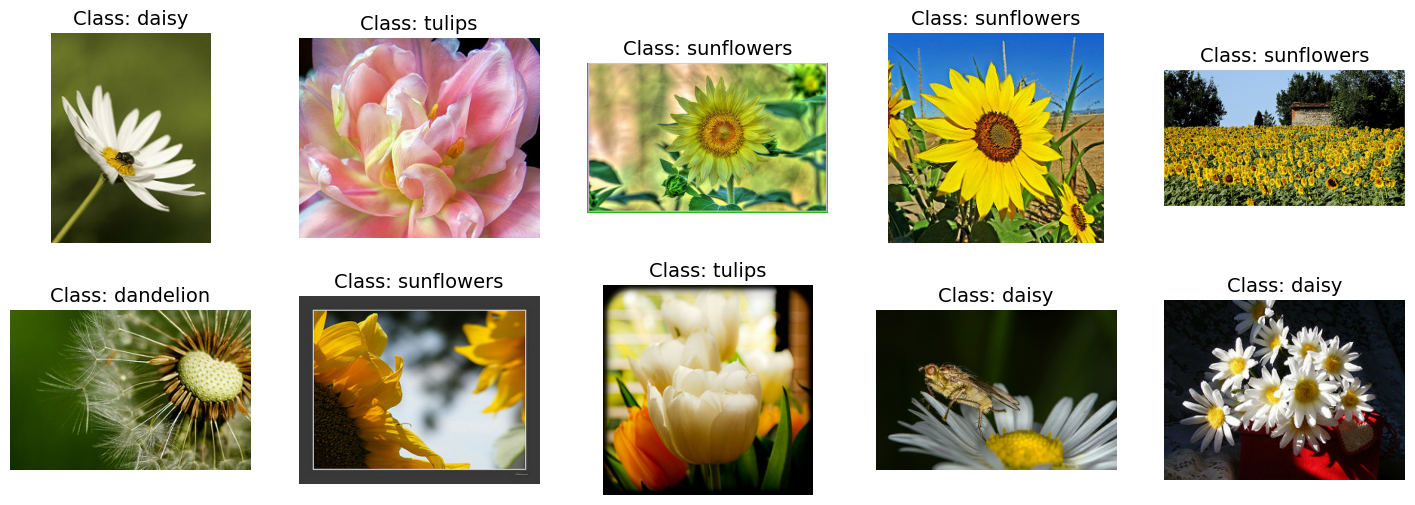

In [12]:
# Some images in the train set

plt.figure(figsize=(18, 6))
index=0
for image, label in train_set_raw.take(10):
  index += 1
  plt.subplot(2, 5, index)
  plt.imshow(image)
  plt.title(f"Class: {class_names[label]}")
  plt.axis("off")
plt.show()

+ We need to ensure that the images have the same size else batching will fail.  So we create a resizing layer.
+ Let's use Xception pretrained model
+ We'll also shuffle and prefetch the training set

In [13]:
model = tf.keras.applications.Xception(weights="imagenet", include_top=True)

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# model.summary()

In [15]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=299, width=299, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

In [16]:
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

In [17]:
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all 224x224 now, with values ranging from -1 to 1:

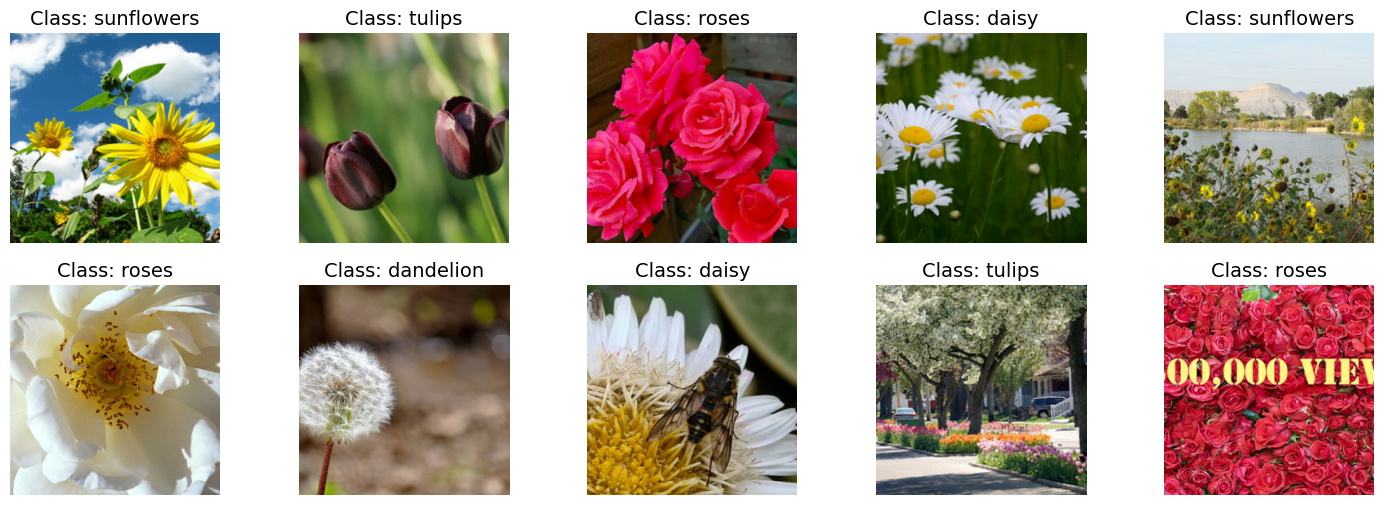

In [18]:
# View the images after resizing and batching

plt.figure(figsize=(18, 6))
index=0
for X_batch, y_batch in train_set.take(10):
  index += 1
  plt.subplot(2, 5, index)
  # print(f"max: {np.max(X_batch[index])}. min: {np.min(X_batch[index])}")
  plt.imshow((X_batch[index] / 2.) + 0.5)
  plt.title(f"Class: {class_names[y_batch[index]]}")
  plt.axis("off")

plt.show();

Each batch contains 32 images
Each image are 224, 224 pixels
The pixels values range from -1 to 1

The dataset is not very large. Let's perform data augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

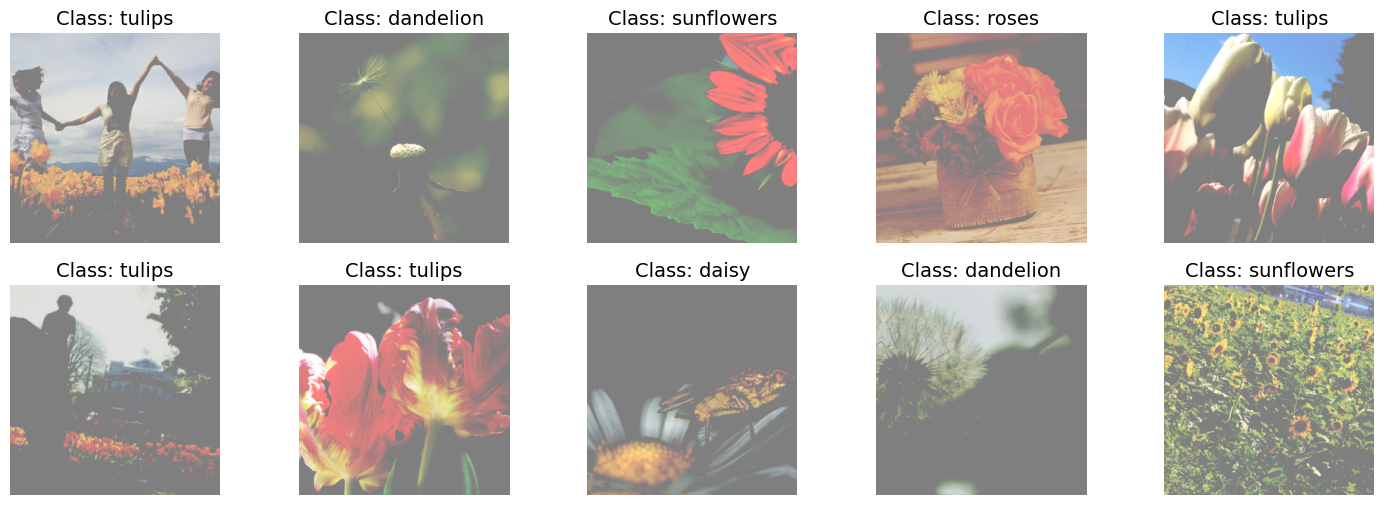

In [20]:
# Display some iamges after algmentation

plt.figure(figsize=(18, 6))
index=0
for X_batch, y_batch in train_set.take(10):
  X_batch_aug = data_augmentation(X_batch, training=True)
  index += 1
  plt.subplot(2, 5, index)
  # change the range to 0 - 1
  range = (X_batch_aug[index] / 2.) + 0.5
  # clip
  clipped = np.clip(range, 0, 1)
  plt.imshow(clipped)
  plt.title(f"Class: {class_names[y_batch[index]]}")
  plt.axis("off")

plt.show();

NOTE

Include the preprocessing or data augmentation layers inside the model, they will benefit from GPU acceleration during training.

# Modelling

Task

+ Load the Xception model pretrained model without it's top layers and replace them with yours for the flower classification task

In [21]:
# model.summary()

In [22]:
base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
# base_model.summary()

The global average pooling layer and the dense output layer have been excluded

Task:
+ Add your own global average pooling layer
+ Add your own output

In [24]:
n_classes = info.features["label"].num_classes
n_classes

5

In [25]:
base_model.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=None, name=keras_tensor_9>

In [26]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

In [27]:
model = tf.keras.Model(inputs=base_model.input, outputs=output)

Freeze the weights of the pretrained layers for now

In [28]:
# base_model.summary()

In [29]:
for layer in base_model.layers:
    layer.trainable = False

In [30]:
# base_model.summary()

WARNING
Since our model uses the base model’s layers directly, rather than the base_model object itself, setting base_model.trainable=False would have no effect.

What is the meaning of this?????????????????

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [31]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [32]:
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 68s 462ms/step - accuracy: 0.7521 - loss: 0.6333 - val_accuracy: 0.8730 - val_loss: 0.3679
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.9344 - loss: 0.2124 - val_accuracy: 0.8893 - val_loss: 0.3203
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - accuracy: 0.9636 - loss: 0.1178 - val_accuracy: 0.8748 - val_loss: 0.3511
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step - accuracy: 0.9589 - loss: 0.1173 - val_accuracy: 0.8875 - val_loss: 0.3531
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - accuracy: 0.9736 - loss: 0.0762 - val_accuracy: 0.8766 - val_loss: 0.3395


In [34]:
# for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
#     for idx in indices:
#         print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
#     print()

+ Now the top layers are not too bad.  
+ Let's make the top part of the base mode trainable again.
+ Let's use a lower learning rate

NOTE
+ After training the model for a few epochs, its validation accuracy should
reach a bit over 80% and then stop improving.  
+ This means that the top layers are now pretty well trained, and we are ready to unfreeze some of the base model’s top layers, then continue training.  
+ For example, let’s unfreeze layers 56 and above (that’s the start of residual unit 7 out of 14, as you can see if you list the layer names):

In [35]:
for layer in base_model.layers[56:]:
    layer.trainable = True

After freezing and unfreezing the model, it needs to be recompiled.

Make sure to use a much lower learning rate to avoid damaging the pretrained weights.

In [36]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [37]:
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 77s 621ms/step - accuracy: 0.9346 - loss: 0.1880 - val_accuracy: 0.8838 - val_loss: 0.4607
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 46s 516ms/step - accuracy: 0.9826 - loss: 0.0582 - val_accuracy: 0.9292 - val_loss: 0.2609
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 46s 508ms/step - accuracy: 0.9968 - loss: 0.0141 - val_accuracy: 0.9310 - val_loss: 0.2467
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 47s 528ms/step - accuracy: 0.9988 - loss: 0.0067 - val_accuracy: 0.9292 - val_loss: 0.2633
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 544ms/step - accuracy: 0.9998 - loss: 0.0027 - val_accuracy: 0.9328 - val_loss: 0.2707
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 47s 504ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9365 - val_loss: 0.2691
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 47s 530ms/step - accuracy: 0.9990 - loss: 0.0024 - val_accuracy: 0.9347 - val_loss: 0.2683
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 46s 510ms/step - accuracy: 0.9985 - loss: 0.0040 - val_accu

This model should reach around 92% accuracy on the test set, in just a few
minutes of training (with a GPU).

If you tune the hyperparameters, lower the learning rate, and train for quite a bit longer, you should be able to reach 95% to 97%.

With that, you can start training amazing image classifiers on your own images and classes!

In [38]:
model.save("flower_classifier.keras")